# Változó számának csökkentése, változó kiválasztás

## F1/a - normál eloszlású változók generálása

In [1]:
import pandas as pd
import numpy as np

In [3]:
np.random.seed(42)

In [15]:
def get_random_df(nrow, ncol):
    random_df = pd.DataFrame()
    for i in range(ncol):
        random_df[f'random_{i}'] = np.random.normal(0, 1, nrow)

    random_df['label'] = random_df.index%2

    return random_df

In [28]:
def get_random_df2(nrow, ncol):
    random_dict = dict()
    for i in range(ncol):
        random_dict[f'random_{i}'] = np.random.normal(0, 1, nrow)

    random_df = pd.DataFrame(random_dict)
    
    random_df['label'] = random_df.index%2

    return random_df

In [29]:
random_df = get_random_df(nrow = 2000, ncol = 1000)

/tmp/ipykernel_41003/3921361262.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  random_df[f'random_{i}'] = np.random.normal(0, 1, nrow)
/tmp/ipykernel_41003/3921361262.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  random_df['label'] = random_df.index%2


In [30]:
random_df = get_random_df2(nrow = 2000, ncol = 1000)

## F1/b - Dimenziók átkának demonstrációja

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

In [33]:
X_train, X_test, y_train, y_test = train_test_split(random_df.drop('label', axis=1), random_df['label'], test_size=0.2, random_state=42)

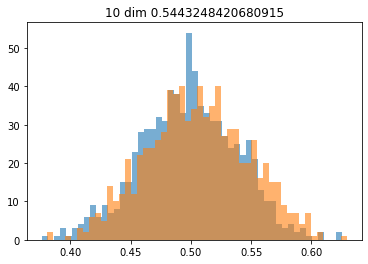

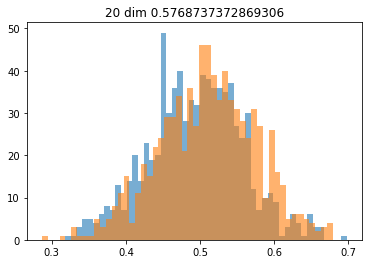

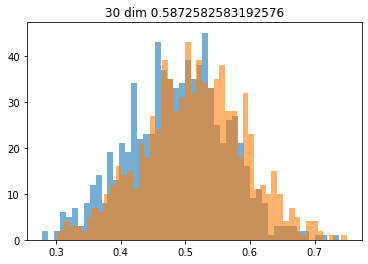

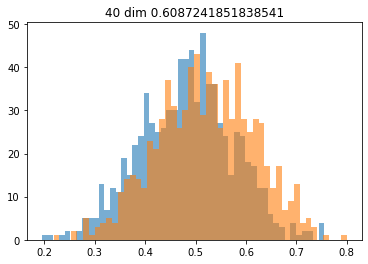

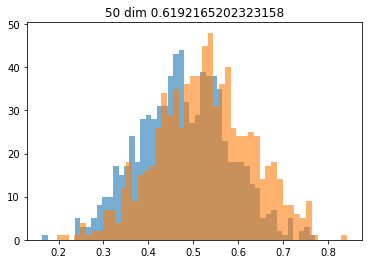

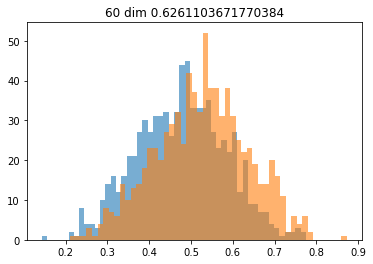

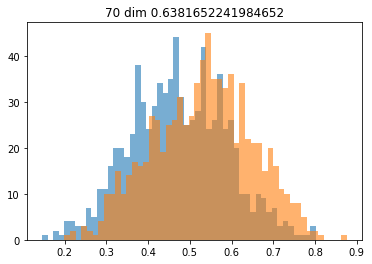

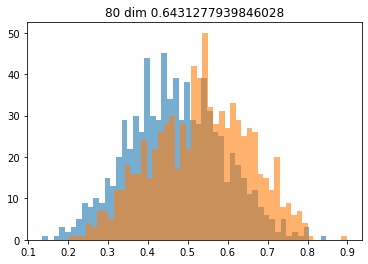

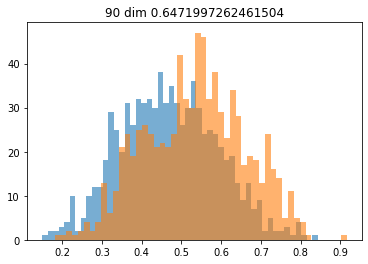

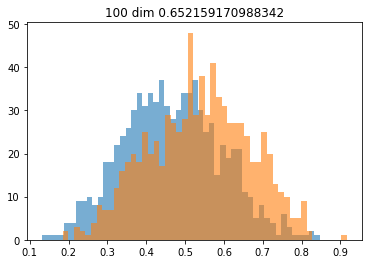

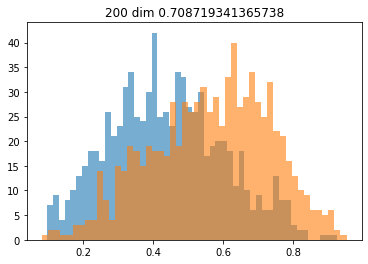

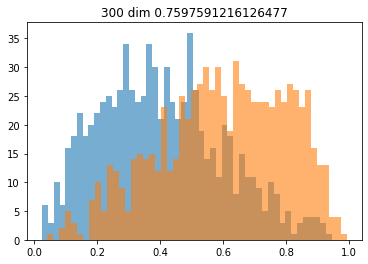

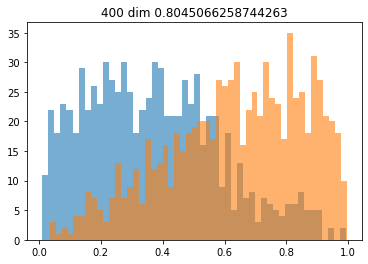

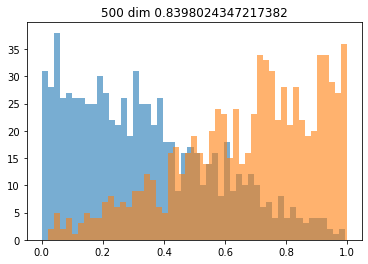

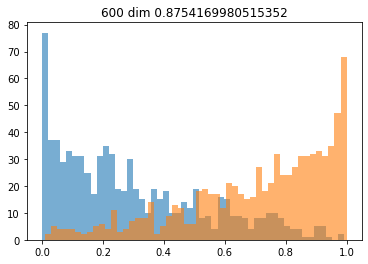

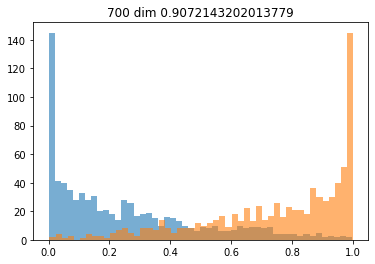

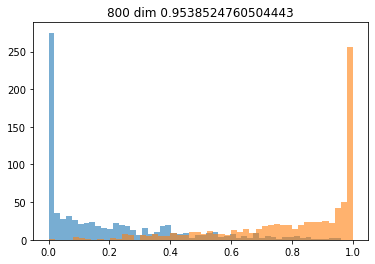

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


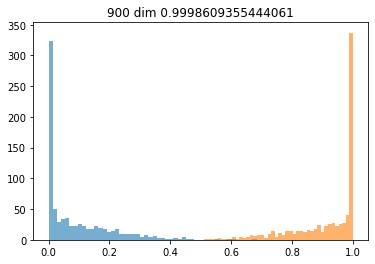

In [72]:
for n_used_vars in list(range(10,100,10)) + list(range(100,1000,100)):

    model = LogisticRegression()
    model.fit(X_train.iloc[:, :n_used_vars], y_train)
    y_pred = model.predict_proba(X_train.iloc[:, :n_used_vars])[:, 1]
    myauc = roc_auc_score(y_train, y_pred)

    plot_df = pd.DataFrame(y_pred, columns=['y_pred'])
    plot_df['label'] = y_train.tolist()

    plt.hist(plot_df.loc[plot_df['label']==0, 'y_pred'], bins=50, alpha=0.6);
    plt.hist(plot_df.loc[plot_df['label']==1, 'y_pred'], bins=50, alpha=0.6);
    plt.title(f'{n_used_vars} dim {myauc}');
    
    plt.show()

In [73]:
y_pred = model.predict_proba(X_test.iloc[:, :n_used_vars])[:, 1]
roc_auc_score(y_test, y_pred)

0.5050386336925808

### F2 -  Mi lenne ha - a lehetséges kombinációk számának megértése / megérzése
Tegyük fel hogy:
- Egy tanítási és tesztelési, kiértékelési ciklus 10ms alatt lefut
- Rendelkezésünkre áll Magyarország összes számítógépe, mondjuk 10 millió számítógép 
- A 64 elemű változólistából minden kombinációt ki akarunk próbálni, kivéve azt, amikor az összes elemet kizárjuk a bemeneti változók közül.

__KÉRDÉS__: Mennyi ideig tartana kipróbálni az összes lehetséges kombinációt ennyi gépen?

In [79]:
2**64 * 10 / 10000000 / 1000 / 60 / 60 /24 /365

584.9424173550719

## F3 - változókiválasztási módszerek összevetéséhez summary baseline-nal

In [129]:
from sklearn.datasets import load_digits

digits=load_digits(as_frame=True)
X = digits.data
y = digits.target

y = y == 3

In [130]:
from sklearn.metrics import log_loss, roc_auc_score

In [131]:
def add_to_summary(summary, X_train, X_test, y_train, y_test, method, model):
    model.fit(X_train, y_train)

    summary.loc[method, 'Logloss - train'] = log_loss(y_train, model.predict_proba(X_train))
    summary.loc[method, 'Logloss - test'] = log_loss(y_test, model.predict_proba(X_test))
    summary.loc[method, 'n_features'] = len(X_train.columns)
    summary.loc[method, 'features'] = list(X_train.columns)
    print(summary.loc[method])

    return summary, model

summary = pd.DataFrame(columns=['Logloss - train', 'Logloss - test', 'n_features', 'features'])

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [133]:
model = LogisticRegression(max_iter=1000, random_state=42)

In [134]:
summary, model = add_to_summary(summary, X_train, X_test, y_train, y_test, method='baseline', model=model)

Logloss - train                                             0.005157
Logloss - test                                               0.10543
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: baseline, dtype: object


## F4 - Korreláció alapú szelekció

In [149]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_predict

In [150]:
X_train_w_label = X_train.join(y_train)
ordered_by_corr = list(abs(X_train_w_label.corr()['target']).sort_values(ascending=False).drop('target').index)
del X_train_w_label

In [157]:
from tqdm import tqdm

In [159]:
topX_corr_perf = {}

for i in tqdm(range(1, len(ordered_by_corr))):
    selected_vars = ordered_by_corr[:i]
    y_pred = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:, 1]
    topX_corr_perf[i] = log_loss(y_train, y_pred)

100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


<AxesSubplot:>

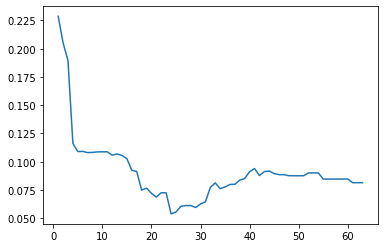

In [162]:
pd.Series(topX_corr_perf).plot()

In [167]:
vars_selected_by_corr_method = ordered_by_corr[:pd.Series(topX_corr_perf).idxmin()]

In [168]:
summary, trained_model = add_to_summary(summary, X_train[vars_selected_by_corr_method], X_test[vars_selected_by_corr_method], y_train, y_test, method='top-corr', model=model)

Logloss - train                                             0.029872
Logloss - test                                              0.058009
n_features                                                        24
features           [pixel_3_2, pixel_4_2, pixel_2_2, pixel_5_3, p...
Name: top-corr, dtype: object


## F5 - Forward selection módszere

### A) ELSŐ ESET: Manual

In [176]:
meg_nem_kivalszott_valtozok = list(X_train.columns)
kivalasztott_valtozok = []
best_logloss = 999
for i in tqdm(range(64)):
    print(f'--------iteráció - {i}')
    nyertes = None
    for versenyzo in meg_nem_kivalszott_valtozok:

        y_pred = cross_val_predict(model, X_train[kivalasztott_valtozok + [versenyzo]], y_train, cv=4, method='predict_proba')[:, 1]
        kivalasztott_es_versenyzo_perf = log_loss(y_train, y_pred)
        if kivalasztott_es_versenyzo_perf < best_logloss:
            print(f'best_logloss-nál jobb: {versenyzo} logloss = {kivalasztott_es_versenyzo_perf}')
            nyertes = versenyzo
            nyertes_perf = kivalasztott_es_versenyzo_perf
            best_logloss = kivalasztott_es_versenyzo_perf
    if nyertes:
        print(f'nyertes: {nyertes}')
        meg_nem_kivalszott_valtozok.remove(nyertes)
        kivalasztott_valtozok.append(nyertes)
        best_logloss = nyertes_perf
    else:
        print('nincs akivel javulna a logloss')
        break

  0%|          | 0/64 [00:00<?, ?it/s]

--------iteráció - 0
best_logloss-nál jobb: pixel_0_0 logloss = 0.329993655611604
best_logloss-nál jobb: pixel_0_1 logloss = 0.32262831716868906
best_logloss-nál jobb: pixel_0_2 logloss = 0.3049615989849849
best_logloss-nál jobb: pixel_1_3 logloss = 0.304453634732758
best_logloss-nál jobb: pixel_2_2 logloss = 0.2700155789472392
best_logloss-nál jobb: pixel_3_2 logloss = 0.2287135045745418


  2%|▏         | 1/64 [00:03<03:11,  3.04s/it]

nyertes: pixel_3_2
--------iteráció - 1
best_logloss-nál jobb: pixel_0_1 logloss = 0.22740363146565185
best_logloss-nál jobb: pixel_0_2 logloss = 0.22334970928646064
best_logloss-nál jobb: pixel_0_4 logloss = 0.2162821762565559
best_logloss-nál jobb: pixel_1_3 logloss = 0.2115354326845489
best_logloss-nál jobb: pixel_3_6 logloss = 0.20084598739146287
best_logloss-nál jobb: pixel_5_2 logloss = 0.1958303449282299
best_logloss-nál jobb: pixel_5_3 logloss = 0.1349611860273731


  3%|▎         | 2/64 [00:06<03:19,  3.22s/it]

nyertes: pixel_5_3
--------iteráció - 2
best_logloss-nál jobb: pixel_0_1 logloss = 0.13076783400050496
best_logloss-nál jobb: pixel_0_2 logloss = 0.13068280494821508
best_logloss-nál jobb: pixel_0_4 logloss = 0.12762760539010679
best_logloss-nál jobb: pixel_1_1 logloss = 0.12632680248180872
best_logloss-nál jobb: pixel_2_2 logloss = 0.12332572018283049
best_logloss-nál jobb: pixel_3_5 logloss = 0.1014243484237952
best_logloss-nál jobb: pixel_3_6 logloss = 0.0962278905433502


  5%|▍         | 3/64 [00:09<03:25,  3.36s/it]

nyertes: pixel_3_6
--------iteráció - 3
best_logloss-nál jobb: pixel_0_1 logloss = 0.09376384702123074
best_logloss-nál jobb: pixel_0_3 logloss = 0.09244820163938162
best_logloss-nál jobb: pixel_0_4 logloss = 0.08204673998952368


  6%|▋         | 4/64 [00:13<03:37,  3.62s/it]

nyertes: pixel_0_4
--------iteráció - 4
best_logloss-nál jobb: pixel_0_1 logloss = 0.07919264124976724
best_logloss-nál jobb: pixel_1_1 logloss = 0.07857370844614003
best_logloss-nál jobb: pixel_1_4 logloss = 0.07725570418136392
best_logloss-nál jobb: pixel_2_2 logloss = 0.0760370435356585
best_logloss-nál jobb: pixel_2_4 logloss = 0.07492344011653335
best_logloss-nál jobb: pixel_3_5 logloss = 0.0746563774297175


  8%|▊         | 5/64 [00:18<03:55,  4.00s/it]

best_logloss-nál jobb: pixel_7_6 logloss = 0.07134283727341201
nyertes: pixel_7_6
--------iteráció - 5
best_logloss-nál jobb: pixel_0_1 logloss = 0.0686639225510312
best_logloss-nál jobb: pixel_1_1 logloss = 0.06829985664274035
best_logloss-nál jobb: pixel_1_4 logloss = 0.06815510034023521
best_logloss-nál jobb: pixel_2_2 logloss = 0.06633107220648132
best_logloss-nál jobb: pixel_2_4 logloss = 0.06613011507475813
best_logloss-nál jobb: pixel_3_5 logloss = 0.06402310349279057
best_logloss-nál jobb: pixel_5_6 logloss = 0.06379350167144526


  9%|▉         | 6/64 [00:23<04:06,  4.25s/it]

nyertes: pixel_5_6
--------iteráció - 6
best_logloss-nál jobb: pixel_0_1 logloss = 0.062301330174195924
best_logloss-nál jobb: pixel_1_4 logloss = 0.062079256947473294
best_logloss-nál jobb: pixel_2_2 logloss = 0.058373186465154506
best_logloss-nál jobb: pixel_3_5 logloss = 0.05656123367961775


 11%|█         | 7/64 [00:28<04:15,  4.48s/it]

nyertes: pixel_3_5
--------iteráció - 7
best_logloss-nál jobb: pixel_0_1 logloss = 0.05587710403466676
best_logloss-nál jobb: pixel_1_4 logloss = 0.05584638634668272
best_logloss-nál jobb: pixel_1_5 logloss = 0.05536798674564719
best_logloss-nál jobb: pixel_2_2 logloss = 0.05184113059893087
best_logloss-nál jobb: pixel_5_2 logloss = 0.04821260735574001


 12%|█▎        | 8/64 [00:33<04:23,  4.70s/it]

nyertes: pixel_5_2
--------iteráció - 8
best_logloss-nál jobb: pixel_0_1 logloss = 0.04815572092925022
best_logloss-nál jobb: pixel_1_4 logloss = 0.04744115708632893
best_logloss-nál jobb: pixel_1_5 logloss = 0.045669500205053136
best_logloss-nál jobb: pixel_2_2 logloss = 0.044316776178477506


 14%|█▍        | 9/64 [00:38<04:29,  4.89s/it]

nyertes: pixel_2_2
--------iteráció - 9
best_logloss-nál jobb: pixel_1_2 logloss = 0.04328822301046992
best_logloss-nál jobb: pixel_1_5 logloss = 0.04066960810189339


 16%|█▌        | 10/64 [00:44<04:35,  5.11s/it]

nyertes: pixel_1_5
--------iteráció - 10
best_logloss-nál jobb: pixel_0_0 logloss = 0.040669608099941905
best_logloss-nál jobb: pixel_0_5 logloss = 0.04009506656276448
best_logloss-nál jobb: pixel_1_4 logloss = 0.038716289408543325
best_logloss-nál jobb: pixel_2_4 logloss = 0.03825122103450994


 17%|█▋        | 11/64 [00:52<05:26,  6.16s/it]

nyertes: pixel_2_4
--------iteráció - 11
best_logloss-nál jobb: pixel_0_0 logloss = 0.03825122103450733
best_logloss-nál jobb: pixel_0_6 logloss = 0.037997985967842575
best_logloss-nál jobb: pixel_2_3 logloss = 0.03745891098531053
best_logloss-nál jobb: pixel_6_2 logloss = 0.037145948691650416
best_logloss-nál jobb: pixel_6_5 logloss = 0.03658986342542594


 19%|█▉        | 12/64 [01:02<06:14,  7.21s/it]

nyertes: pixel_6_5
--------iteráció - 12
best_logloss-nál jobb: pixel_0_6 logloss = 0.035397322818302566


 20%|██        | 13/64 [01:12<06:56,  8.16s/it]

nyertes: pixel_0_6
--------iteráció - 13
best_logloss-nál jobb: pixel_1_2 logloss = 0.03482424452764169
best_logloss-nál jobb: pixel_2_3 logloss = 0.03433535439893252


 22%|██▏       | 14/64 [01:23<07:31,  9.03s/it]

nyertes: pixel_2_3
--------iteráció - 14
best_logloss-nál jobb: pixel_1_3 logloss = 0.03416773505785158
best_logloss-nál jobb: pixel_4_1 logloss = 0.03347052809504322


 23%|██▎       | 15/64 [01:39<09:04, 11.11s/it]

nyertes: pixel_4_1
--------iteráció - 15
best_logloss-nál jobb: pixel_0_7 logloss = 0.03345163408069209


 25%|██▌       | 16/64 [02:02<11:35, 14.50s/it]

best_logloss-nál jobb: pixel_7_7 logloss = 0.033443859183640574
nyertes: pixel_7_7
--------iteráció - 16
best_logloss-nál jobb: pixel_0_1 logloss = 0.03335911084931708
best_logloss-nál jobb: pixel_1_6 logloss = 0.03322178708913312


 27%|██▋       | 17/64 [02:24<13:07, 16.76s/it]

nyertes: pixel_1_6
--------iteráció - 17
best_logloss-nál jobb: pixel_1_3 logloss = 0.03255977532016455
best_logloss-nál jobb: pixel_1_4 logloss = 0.030580248248356423


 28%|██▊       | 18/64 [02:49<14:52, 19.41s/it]

nyertes: pixel_1_4
--------iteráció - 18
best_logloss-nál jobb: pixel_1_0 logloss = 0.030580129265411683
best_logloss-nál jobb: pixel_1_7 logloss = 0.030575226783554406
best_logloss-nál jobb: pixel_5_4 logloss = 0.030124904064355664


 30%|██▉       | 19/64 [03:16<16:05, 21.46s/it]

nyertes: pixel_5_4
--------iteráció - 19
best_logloss-nál jobb: pixel_0_0 logloss = 0.0301239922563655
best_logloss-nál jobb: pixel_1_7 logloss = 0.030117269706335565
best_logloss-nál jobb: pixel_4_2 logloss = 0.030017324760294787


 31%|███▏      | 20/64 [03:43<17:01, 23.22s/it]

nyertes: pixel_4_2
--------iteráció - 20
best_logloss-nál jobb: pixel_1_7 logloss = 0.02999999281522247
best_logloss-nál jobb: pixel_6_7 logloss = 0.029485457062378203


 33%|███▎      | 21/64 [04:13<18:05, 25.25s/it]

nyertes: pixel_6_7
--------iteráció - 21
best_logloss-nál jobb: pixel_0_7 logloss = 0.029485358136291127
best_logloss-nál jobb: pixel_1_0 logloss = 0.02948384614405605
best_logloss-nál jobb: pixel_1_7 logloss = 0.02946363809766391


 34%|███▍      | 22/64 [04:46<19:23, 27.70s/it]

nyertes: pixel_1_7
--------iteráció - 22
best_logloss-nál jobb: pixel_3_0 logloss = 0.02946312138877238
best_logloss-nál jobb: pixel_3_7 logloss = 0.029463032581124555


 36%|███▌      | 23/64 [05:20<20:15, 29.64s/it]

nyertes: pixel_3_7
--------iteráció - 23
best_logloss-nál jobb: pixel_3_0 logloss = 0.02946227783855187


 38%|███▊      | 24/64 [05:58<21:22, 32.05s/it]

nyertes: pixel_3_0
--------iteráció - 24


 38%|███▊      | 24/64 [06:30<10:50, 16.26s/it]

nincs akivel javulna a logloss


In [178]:
summary, trained_model = add_to_summary(summary, X_train[kivalasztott_valtozok], X_test[kivalasztott_valtozok], y_train, y_test, method='manual-Forward', model=model)

Logloss - train                                             0.014867
Logloss - test                                              0.061981
n_features                                                        24
features           [pixel_3_2, pixel_5_3, pixel_3_6, pixel_0_4, p...
Name: manual-Forward, dtype: object


### B) SequentialFeatureSelector fixált n_feature esetén

In [179]:
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector

In [181]:
myscorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [182]:
sfs = SequentialFeatureSelector(model, n_features_to_select=24, cv=4,  scoring=myscorer)

In [183]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=4,
                          estimator=LogisticRegression(max_iter=1000,
                                                       random_state=42),
                          n_features_to_select=24,
                          scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [186]:
selected_by_sfs = list(X_train.columns[sfs.get_support()])

In [187]:
summary, trained_model = add_to_summary(summary, X_train[selected_by_sfs], X_test[selected_by_sfs], y_train, y_test, method='forward_fix24', model=model)

Logloss - train                                             0.014869
Logloss - test                                              0.061972
n_features                                                        24
features           [pixel_0_4, pixel_0_6, pixel_1_4, pixel_1_5, p...
Name: forward_fix24, dtype: object


In [190]:
set(kivalasztott_valtozok) - set(selected_by_sfs)

{'pixel_3_7'}

## C) SequentialFeatureSelector auto n_feature esetén

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
summary, trained_model = add_to_summary(summary, X_train[], X_test[], y_train, y_test, method='forward_sfs', model=model)

## F6 - Recursive feature elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [191]:
cols_by_rfe = ['pixel_0_4', 'pixel_1_4', 'pixel_1_6', 'pixel_2_2', 'pixel_3_2',
       'pixel_3_5', 'pixel_3_6', 'pixel_4_1', 'pixel_5_2', 'pixel_5_3',
       'pixel_5_6', 'pixel_7_7']

In [192]:
summary, trained_model = add_to_summary(summary, X_train[cols_by_rfe], X_test[cols_by_rfe], y_train, y_test, method='RFE', model=model)

Logloss - train                                             0.026976
Logloss - test                                              0.081643
n_features                                                        12
features           [pixel_0_4, pixel_1_4, pixel_1_6, pixel_2_2, p...
Name: RFE, dtype: object


## F7 - Model alapú megoldások - Logisztikus regresszió coeficiennsei 

In [194]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Index(['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4',
       'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1',
       'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6',
       'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3',
       'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0',
       'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5',
       'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2',
       'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7',
       'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4',
       'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1',
       'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6',
       'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3',
       'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7'],
      dtype='object')

In [204]:
ordered_by_coef = list(abs(pd.Series(model.coef_[0], index = X_train.columns)).sort_values(ascending=False).index)

In [205]:
topX_perf = {}
for i in tqdm(range(1, len(ordered_by_coef))):
    selected_vars = ordered_by_coef[:i]
    y_pred = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:, 1]
    topX_perf[i] = log_loss(y_train, y_pred)

100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


<AxesSubplot:>

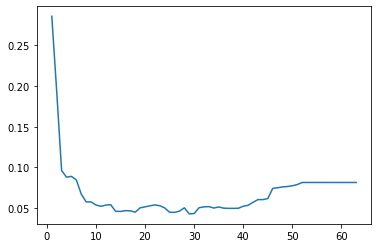

In [207]:
pd.Series(topX_perf).plot()

In [208]:
pd.Series(topX_perf).idxmin()

29

In [209]:
summary, trained_model = add_to_summary(summary, X_train[ordered_by_coef[:29]], X_test[ordered_by_coef[:29]], y_train, y_test, method=f'model_based_logreg', model=model)

Logloss - train                                             0.007637
Logloss - test                                              0.099536
n_features                                                        29
features           [pixel_3_6, pixel_5_3, pixel_3_2, pixel_3_5, p...
Name: model_based_logreg, dtype: object


## F8 - Változó kiválasztás lasso regresszió segítségével

$ célfüggvény = ModellHibájaAPontokon + \frac{1}{C}*ModellKomplexitás = ModellHibájaAPontokon + \frac{1}{C} * \sum_{i=1}^{m}|\alpha_i|$

In [ ]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 5, 10, 25, 50, 100]

In [ ]:
summary, model_trained = add_to_summary(summary, X_train[], X_test[], y_train, y_test, method=f'lasso', model=model)


## F9 - model_based (gbm + feature_importance)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
summary, trained_model = add_to_summary(summary, X_train[], X_test[], y_train, y_test, method=f'model_based_gbm', model=model)

## F10 - melyik pixelt választják ki legtöbbször a különböző módszerek?

In [ ]:
methods = ['top-corr', 'manual-Forward', 'RFE', 'model_based_logreg', 'model_based_gbm', 'lasso']
selected_vars_all = summary.loc[methods, 'features'].tolist()
falttened_selected_vars_all = [selected_feature for selected_features in selected_vars_all for selected_feature in selected_features]

In [ ]:
selected_times={}
for pixel in X_train.columns:
    selected_times[pixel]=0

In [ ]:
for used_pixel in falttened_selected_vars_all:
    selected_times[used_pixel]=selected_times[used_pixel]+1

In [ ]:
plt.imshow(np.array(list(selected_times.values())).reshape(8, 8), cmap='gray_r')
plt.colorbar()

In [ ]:
[i for i in selected_times.values() if i == 6]

## Konklúzió - vizualizáljuk az egyes módszerekkel kiválasztott pixelek milyen súllyal kerülnek be a modellbe

In [ ]:
def scale01(s):
        return (s-s.min())/(s.max()-s.min())

for method in methods:
    selected_vars_with_method = summary.loc[methods[0], "features"]
    plt.figure(figsize=(8,8))
    vars64 = np.array([1 if str(item) in selected_vars_with_method else 0 for item in X_train.columns])
    plt.imshow(vars64.reshape(8, 8), cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'selected features @{method}')
    plt.colorbar()
    plt.show()

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train[selected_vars_with_method], y_train)
    all_pixels_weights = pd.DataFrame(index=X_train.columns)
    all_pixels_weights = all_pixels_weights.join(pd.DataFrame(model.coef_[0], index=selected_vars_with_method))
    all_pixels_weights = all_pixels_weights.fillna(0)

    negative_coefs = all_pixels_weights.loc[all_pixels_weights[0]<0]
    scaled_negatives_to_minus1_0 = scale01(negative_coefs)-1
    positive_coefs = all_pixels_weights.loc[all_pixels_weights[0]>0]
    scaled_positives_to_0_1 = scale01(positive_coefs)
    all_pixels_weights['scaled'] = pd.concat([scaled_negatives_to_minus1_0, scaled_positives_to_0_1])
    all_pixels_weights['scaled'] = all_pixels_weights['scaled'].fillna(0)

    all_pixels_weights_array = np.array(all_pixels_weights['scaled'].tolist())
    plt.figure(figsize=(8,8))
    plt.imshow(all_pixels_weights_array.reshape(8, 8), cmap='bwr')
    plt.colorbar()
    plt.title(f'weights for features @{method}')
    plt.show()